**Introduction.**

In this Jupyter Notebook, we will write an implementation of Moser's Fix-It Algorithm in order to solve problem 5.8.7 from The Probabilistic Method by Noga Alon.

The accompanying paper can be found here: https://arxiv.org/abs/0903.0544

We restate the problem here for completeness:

`Problem:` Set $m=10^5$ and $n = 10m$. Let $x[1],...,x[n]$ be Boolean variables. Let $\sigma_1, ..., \sigma_{30}$ be permutations of $1,...,n$. For each $1 \leq i \leq 30$ and $0 \leq t < m$, create a clause $C=y[1]\lor \cdots \lor y[10]$ where $y[l]$ is either $x[\sigma_i(10t+l)]$ or its negation. Show, using the Local Lemma, that the conjunction of all $30m$ clauses is satisfiable. Selecting the permutations at random, and the $y[l]$ at random, implement the FIX-IT algoirthm to find a satisfying assignment.

**The Algorithm.**
Some notation:
For some context, let $\Omega$ be a finite set. For each $v \in \Omega$, let $C[v]$ denote a random variable. $\Omega$ and $C[v]$ define a probability space. Let $I$ denote an index set. For each $\alpha \in I$, there is an associated set $A[\alpha] \subset \Omega$ and an event $BAD[\alpha]$ that depends only on the values of $C[v]$ for $v \in A[\alpha]$. The algorithm is therefore designed to find specific values (realizations) of $C[v]$ so that no $BAD[\alpha]$ holds. 

`Mosers' FIX-IT ALGORITHM`:
1. For each $v\in \Omega$, choose $C[v]$ according to its distribution.
2. _WHILE_ at least one $BAD[\alpha]$ holds:
3. Select one $\alpha \in I$ for which $BAD[\alpha]$
4. Reset $C[v]$ for each $v \in A[\alpha]$
5. _END WHILE_

In our case, for the above example, the index set $I$ corresponds to the $30m$ clauses that we will construct. That is, $i\in I$ will access a list $A[i] \in A$ so that $A[i]$ contains the (index) elements making up the $i$th clause $C$. More precisely, for each $v_j \in A[i]$, $(1 \leq j \leq 10)$, the random variable $C[v_j]$ will correspond to the $j$th _literal_ in the $i$th clause $C$.


**The Implementation.**

Our implementation will consist of several steps. First, we will generate a set of Boolean random variables $x[1], ..., x[n]$ by flipping a coin for each integer $i \in [1, n]$, then fix each $x[i]$ for the rest of the program. These Boolean variables will be stored in an array $C$ so that $C[i]$ accesses the $i$th Boolean variable: `C[i] = x[i]`.

We will then generate a set of random permutations $\sigma_1, ..., \sigma_{30}$ by randomly permuting a list `L=[1,2,...,n]` to form another list `sigma_i` so that accessing the $k$th element in `sigma_i` gives us the permuted element of the integer $k$: $\sigma_i(k)$. That is, `sigma_i[k]` will return the element $\sigma_i(k)$. For example, if `L=[1,2,3]` and `sigma_i = [3,1,2]` then accessing `sigma_i[1] = 3` -- working similarly to the permutation $\sigma_i(1) = 3$.

Once we have these tools, we will generate our clauses in the form of generating the sets $I$ and $A$. Here $i \in I$ will correspond to the $i$th clause $C$, and then accessing the list `A` will return another list `A[i]`, which contains the indices making up the $i$th clause. For example, if `A[i]` is the index elements to the $i$th clause $C$, and we want to access the $2$nd literal in $C$, we would use `v2 = A[i][2]` as our index: `C[v2] = second element of C`: corresponding to using $v_2 \in A[i]$ to denote random variable $C[v_2]$.

So, once we have constructed our list-of-lists $A$, we have essentially generated all our clauses. The event $BAD[i]$ then corresponds to the case that the $i$th clause $C$ is false -- something we want to avoid. To determine if a clause $C$ is false, we can make a pass through $A$ to access our clauses, and then for each $v \in A[i]$, access the literal $C[v]$ corresponding to the $i$th clause and check if it's false. If all literals in corresponding to the clause is false, then the entire clause is false, and we then add $i$ to a set containing the indices for "bad" clauses.

In [1]:
# Numpy for easier computations, matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generates the booleans x[1],...,x[n]
def generate_sample_space(n=10):
    bools = [True if np.random.uniform(0, 1) > 0.50 else False for x in range(n)]
    return(bools)

# Generates the permutations sigma_i for 1 <= i <= 30
def generate_permutations(num, n):
    n_set = np.arange(n)
    permutations = [np.random.permutation(n_set) for i in range(num)]
    return(permutations)

# Constructs the indices that make up our clauses
def generate_index_set(n, m, perms):
    A = []
    for i in range(30):
        sigma_i = perms[i]
        for t in range(0, m):
            A_alpha = []
            for l in range(10):
                j = 10*t + l
                v = sigma_i[j]
                A_alpha.append(v)
            A.append(A_alpha)
    return(A)

# Helper function to help us count the number of BAD[i] events
def count_BAD(A, C):
    num_bad = 0
    bad_index = []
    for i in range(len(A)):
        num_true = 0
        clause_truth = any([C[v] for v in A[i]])
        if clause_truth == False:
            bad_index.append(i)
            num_bad += 1
    return(bad_index, num_bad)

**Aside:** It's actually an exercise in `The Probabilistic Method` to come up with a data structure to do the job that `count_BAD` does. Essentially `count_BAD` will count up all our bad events $BAD[\alpha]$ after each iteration of the _WHILE_ loop in the _FIX-IT_ algorithm.

Let _TLOG_ denote the number of times the _WHILE_ loop does an iteration. In the worst case, each of the $m$ clauses could be false on every iteration, and so the time complexity will cost $\Theta(m\cdot TLOG)$ to run the algorithm - which is not ideal. Let $d$ denote the number of dependencies among each bad event. Apparently using the right data structure will reduce this time to $O(m + (d+1)TLOG)$ in the worst case, which is considerably better since, in general, $d$ needs to be much smaller than $m$ in order for the Local Lemma (and hence the algorithm) to work.

If there is time, we can try to solve this problem and implement the data structure, but for now we will just count up the bad events every time. The running time isn't a problem for $m < 10^5$, but does seem to get tremendously worse when $m \geq 10^5$.

Let's proceed with constructing our objects of interest.

In [3]:
m = 10**4
n = 10*m    # The number of booleans to make
C = generate_sample_space(n=n)    # Generates all the Booleans
sigma = generate_permutations(num=30, n=n)    # Creates our permutations
A = generate_index_set(n, m, sigma)    # Constructs the index set that forms our clauses

Here is a slice of what $A$ looks like:

In [4]:
for alpha in range(5):
    print("The indices 'v' in A[{}] are:".format(alpha))
    print(A[alpha])

The indices 'v' in A[0] are:
[87425, 12436, 59115, 99944, 48545, 88808, 26335, 24137, 36269, 40387]
The indices 'v' in A[1] are:
[80090, 21656, 21326, 40240, 33658, 20924, 92201, 24804, 90825, 54962]
The indices 'v' in A[2] are:
[14023, 34428, 38898, 7281, 45358, 8543, 71710, 43237, 71739, 87518]
The indices 'v' in A[3] are:
[9937, 49240, 90835, 78840, 25050, 86752, 50218, 12531, 28413, 77410]
The indices 'v' in A[4] are:
[95784, 8234, 52831, 82297, 51974, 67827, 41851, 60500, 82468, 81900]


We can also print out the literals in a clause:

In [5]:
for i, v in enumerate(A[0]):
    print("The {}th literal in the 1st clause is: x[{}] = {}".format(i+1, v, C[v]))

The 1th literal in the 1st clause is: x[87425] = True
The 2th literal in the 1st clause is: x[12436] = False
The 3th literal in the 1st clause is: x[59115] = False
The 4th literal in the 1st clause is: x[99944] = True
The 5th literal in the 1st clause is: x[48545] = True
The 6th literal in the 1st clause is: x[88808] = False
The 7th literal in the 1st clause is: x[26335] = True
The 8th literal in the 1st clause is: x[24137] = True
The 9th literal in the 1st clause is: x[36269] = True
The 10th literal in the 1st clause is: x[40387] = True


Now we count up the number of events $BAD[\alpha]$:

In [6]:
BAD, num_bad = count_BAD(A, C)
print("The number of events in BAD is {}".format(num_bad))

The number of events in BAD is 288


We can inspect the clause associated with one of these bad events:

In [7]:
alpha = BAD[0]
for i, v in enumerate(A[alpha]):
    print("The {}th literal in the {}th clause is: x[{}] = {}".format(i+1, alpha, v, C[v]))

The 1th literal in the 178th clause is: x[33854] = False
The 2th literal in the 178th clause is: x[19500] = False
The 3th literal in the 178th clause is: x[88469] = False
The 4th literal in the 178th clause is: x[66814] = False
The 5th literal in the 178th clause is: x[47232] = False
The 6th literal in the 178th clause is: x[8043] = False
The 7th literal in the 178th clause is: x[21443] = False
The 8th literal in the 178th clause is: x[84599] = False
The 9th literal in the 178th clause is: x[47135] = False
The 10th literal in the 178th clause is: x[18944] = False


So, we can easily see that the clause is False overall.

In order to get rid of these clauses, we will run the _FIX-IT_ algorithm.

At a high level, this algorithm is going to fix all the clauses that evaluate to $True$, and for the clauses that evaluate to $False$, they will be 'reset' according to their distribution. In our case, $BAD$ will be a list holding our bad events. We will take an index $\alpha \in BAD$ and inspect the clause associated with the index $\alpha$ by accessing $A[\alpha] \in A$, which is a list holding the literals $x[v]$ for $v\in A[\alpha]$. Thus $C[v]$ will correspond to a random variable that is $True$ or $False$ with probability $1/2$. We simply flip a coin for each $C[v]$ associated with $A[\alpha], \alpha \in BAD$ and then proceed to the next iteration.

Let $TLOG$ be a random variable that denotes the number of _while_ loop iterations. We claim that the expected value of $TLOG$ is finite. That is $E[TLOG] < \infty$. If we can show this, then the _FIX-IT_ algorithm will terminate with probability $1$.

This is easy to show, since we can just appeal to the theorems $5.7.4$ and $5.7.5$ in `The Probabilistic Method`. Let $p = Pr[BAD[\alpha]]$, the probability of a bad event. If $p \leq (d-1)^{d-1} d^{-d}$, then $E[TLOG] \leq |I|/(d-1)$, where $d$ is the number of dependencies for $BAD[\alpha]$ and $I$ is the index set for the number of clauses. Since $|I| = 30m < \infty$, it's enough to just verify the above.

In our analysis (given seperately), we found that $p \leq \frac{1}{1024}$ and that $d = 300$. We can verify the claim with a quick computation:

In [8]:
d = 300
numerator = (d-1)**(d-1)
denominator = d**d
value = numerator / denominator
p = 1/1024
print("Does p < (d-1)^(d-1) * d^(-d) hold?: {}".format((p < value)))

Does p < (d-1)^(d-1) * d^(-d) hold?: True


Thus the $E[TLOG] < \infty$ and the algorithm will terminate with probability $1$.

A secondary condition to give the same claim is if $e p d \leq 1$, but this was actually shown in our analysis. In any case, we proceed with the algorithm.

In [9]:
TLOG = 0
NUM_BAD = []
while num_bad > 0:
    alpha = np.random.choice(BAD)
    for v in A[alpha]:
        C[v] = (np.random.uniform() > 0.50)
    BAD, num_bad = count_BAD(A, C)
    NUM_BAD.append(num_bad)
    TLOG += 1

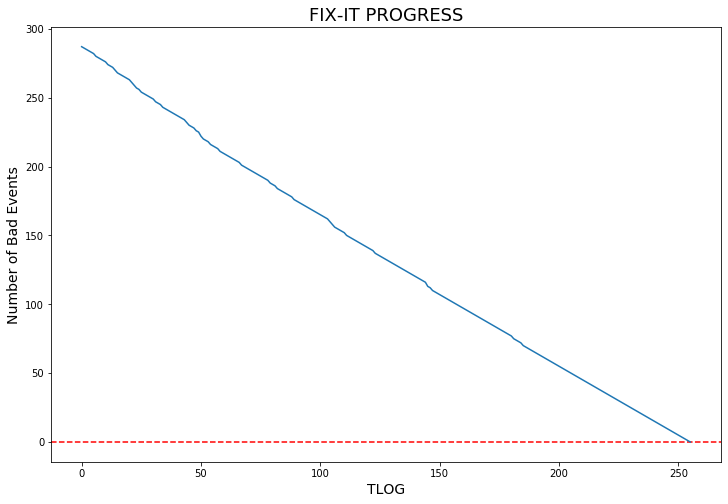

In [10]:
plt.figure(figsize=(12,8))
plt.title("FIX-IT PROGRESS", fontsize=18)
plt.ylabel("Number of Bad Events", fontsize=14)
plt.xlabel("TLOG", fontsize=14)
plt.axhline(color='Red', linestyle='--')
plt.plot(np.arange(TLOG), NUM_BAD)
plt.show()

The above plot then shows that after a number of iterations, the number of bad events slowly tended towards $0$, until we found a satisfying assignment. To verify, we do a quick scan over all the clauses and make sure that none of them are false.

In [11]:
num_clauses = len(A)
num_true_clauses = 0
for i in range(num_clauses):
    clause_truth = any([C[v] for v in A[i]])
    num_true_clauses += clause_truth
    
print("The number of true clauses is {} out of {}".format(num_true_clauses, num_clauses))

The number of true clauses is 300000 out of 300000


Looks like the algorithm works!